In [1]:
'''
Create clustermap and cluster groups for puzzle embeddings
'''
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#Read in puzzle embeddings
temp = pd.read_csv("~/ChessPuzzleEmbeddings/bpr_puzzle_vecs.tsv", sep='\t', header=None)
puzzle_data = pd.read_csv('~/ChessPuzzleEmbeddings/bpr_meta.tsv',sep='\t')

temp.set_index(puzzle_data['tactics_problem_id'],inplace=True)
#temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [3]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
tactics_problem_id,,,,,,,,,,,,,,,,,,,,,
30668,0.139197,0.264141,0.396173,0.087985,0.388567,-0.501616,0.237785,-0.098998,0.273102,0.301020,...,0.237946,0.004284,0.076669,-0.382026,0.164661,0.358423,0.031802,-0.113895,0.330102,0.360762
31142,-0.408487,0.087873,-0.499600,0.046505,-0.025925,-0.224534,0.097014,0.202285,-0.132566,-0.294839,...,-0.326656,-0.080058,-0.420554,-0.191875,0.413164,-0.175699,0.228500,0.150604,-0.273694,0.277080
29034,-0.099101,-0.108522,-0.084490,-0.199117,-0.353021,-0.079497,-0.072233,0.271281,-0.163038,-0.180641,...,-0.131105,-0.145775,-0.146954,0.210088,-0.047004,-0.228523,-0.014035,-0.078149,-0.204257,0.169606
30498,0.172766,0.398972,0.116652,0.208441,0.161459,-0.395151,0.264167,-0.242528,0.265942,0.565358,...,-0.213048,-0.027924,0.115246,-0.237537,0.327599,0.211191,0.164226,-0.128213,0.484196,0.295239
27538,0.018400,-0.080064,-0.211510,-0.566636,-0.189660,0.174939,0.137635,0.308451,0.023096,-0.467175,...,-0.142169,-0.396336,0.020206,0.143934,0.026265,-0.073786,-0.000593,0.165724,0.026220,0.177491


In [5]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
sample_size=2000
np.random.seed(100)
#Contain the IDs for the randomly sampled puzzles
sampled_problems = np.random.choice(puzzle_data['tactics_problem_id'], size = sample_size, replace = False)
#Generate the cosine distance matrix (as Pandas DF) given a list of IDs in the embeddings
def generate_matrix(sampled_problems):
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table
#Generate a cosine distance matrix from the sampled problems
table=generate_matrix(sampled_problems)

In [6]:
table.shape

(2000, 2000)

In [7]:
#Get linkage for randomply sampled Puzzles

#Do clustering on condendesed distance matrix
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(table), method='complete')

#To generate a cosine distance matrix for all the puzzles and assign each of them a cluster
#Note: Running the clustermap with this approach will not work
#linkage = hc.linkage(temp.loc[temp.index], method='complete')

In [8]:
#Test the linkage 
from scipy.cluster.hierarchy import cophenet

cophenet(linkage)[0]

1.896

In [9]:
#Cluster the puzzles into k amount of clusters and then associate each cluster category to puzzle id
from operator import itemgetter
from scipy.cluster.hierarchy import fcluster
k=20
cluster = fcluster(linkage, k, criterion='maxclust')
prob_pair = list(zip(list(sampled_problems), list(cluster)))

In [10]:
#Generate cluster color pallete
nums = list(range(1,k+1))
palette = sns.color_palette("hls", k)
lut = dict(zip(nums, palette))
colors = {}
for pair in prob_pair:
    colors[pair[0]] = lut[pair[1]]
colors = pd.Series(sampled_problems,index=sampled_problems).map(colors)
#colors = pd.Series(colors).reset_index().drop('index',axis=1)

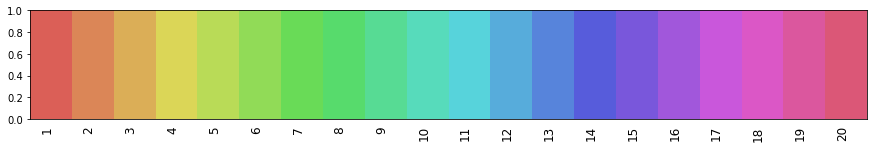

In [11]:
import matplotlib
import matplotlib.pyplot as plt

n=15
size = n/k
fig = plt.figure(figsize=(n,2))
ax = fig.add_subplot(111)
index = 0
for tag in lut:
    plt.text(index+(size/4), -0.15, tag, fontsize=12,rotation="vertical")
    rect = matplotlib.patches.Rectangle((index,0), size, 2, color=lut[tag])
    ax.add_patch(rect)
    index += size
#ax.set_xticklabels(tag_vals,)
plt.xlim([0, n]) 
plt.tick_params(axis='x',  # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

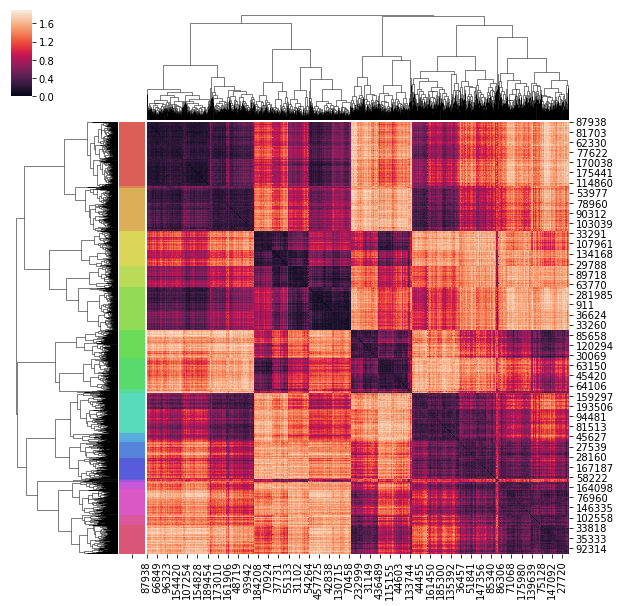

In [12]:
#Set row and column linkage to the clustering genrated above and print heatmap
import seaborn as sns
sns.clustermap(table, row_linkage=linkage, col_linkage=linkage,row_colors=colors)
#plt.savefig('../plots/presentation/word2vec_clustermap_2k.png')

In [13]:
#Create a list of tags that were sampled
sampled_tags = puzzle_data.set_index('tactics_problem_id').loc[sampled_problems]['tag']

In [14]:
#Create dictionary of clusters that map to lists of the tags in those clusters
cluster_to_tag = {}
for i in range(1,k+1):
    cluster_to_tag[i] = []

for i in range(len(sampled_problems)):
    #Get Cluter ID from puzzle ID
    cluster_id = prob_pair[i][1]
    tag = sampled_tags.loc[prob_pair[i][0]]
    cluster_to_tag[cluster_id].append(tag) 

In [15]:
#Sort sampeld tags count dictionary in reverse order
sorted_ids = sorted(cluster_to_tag,key= lambda x: len(cluster_to_tag[x]),reverse=True)

In [16]:
sorted_ids

[1, 3, 6, 10, 4, 8, 20, 7, 18, 5, 14, 13, 19, 12, 17, 9, 2, 16, 15, 11]

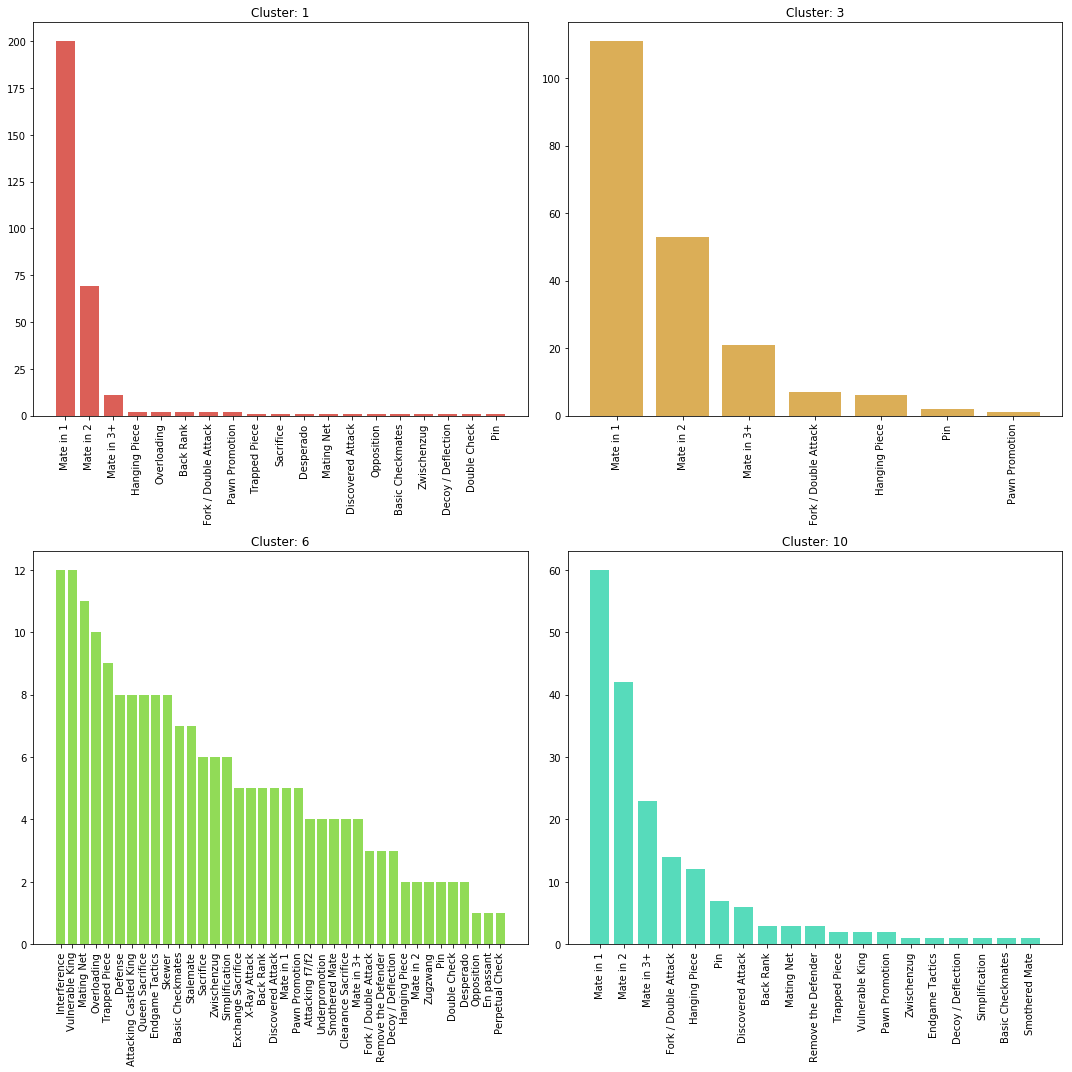

In [17]:
from collections import Counter
from operator import itemgetter

#Create an nxn diagram of the top n^2 clusters in terms of their count
n = 2

fig, axs = plt.subplots(n,n,figsize=(15,15))

counter = 1
for i in range(n):
    for j in range(n):
        current_id = sorted_ids[counter-1]
        data = cluster_to_tag[current_id]
        data = dict(Counter(data))
        data = dict(sorted(data.items(),key=lambda x: x[1],reverse=True))
        axs[i,j].bar(data.keys(),data.values(),color=lut[current_id])
        axs[i,j].set_title('Cluster: '+str(current_id))
        #axs[i,j].tick_params(axis='x',bottom=False,labelbottom=False)
        axs[i,j].set_xticklabels(data,rotation='vertical',fontsize=10)
        #ax.set_xlabel('Tag')
        #ax.set_ylabel('Frequnecy')
        counter += 1
plt.tight_layout()
#plt.savefig('2000_sample_bpr_clustermap_hists_4x4.png')

In [ ]:
#If the linkage was calculated for all the puzzles, then this will add a new column to the puzzle metadata
#with the clusters
puzzle_data['bpr_cluster'] = cluster
puzzle_data.head()

In [ ]:
#Save the puzzle metadata with the new column cluster
puzzle_data.to_csv('bpr_meta.tsv',sep='\t',index=False,header=True)